In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from tensorflow.keras import Sequential, layers, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model

mpl.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "lines.linewidth": 1.5,
    "lines.markersize": 5,
    "axes.linewidth": 1,
})

tf.random.set_seed(1234)
np.random.seed(1234)

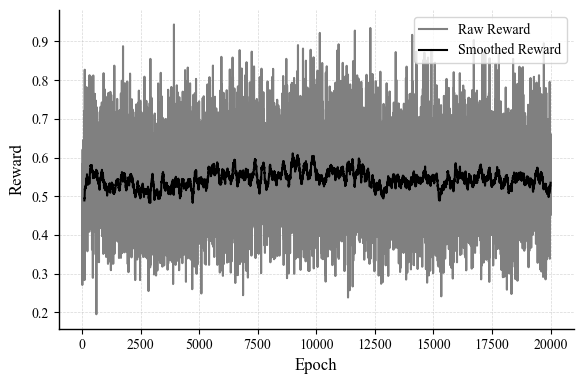

In [ ]:
'''

First try: Simple policy gradient + Reinforce

'''

def get_bounds_from_csv(filename):
    df = pd.read_csv(filename)
    nu_min = df['Nu'].min()
    nu_max = df['Nu'].max()
    dp_min = df['dP'].min()
    dp_max = df['dP'].max()
    return (nu_min, nu_max), (dp_min, dp_max)

bounds = {
    0: {  # eg
        'nu': get_bounds_from_csv("cooling_eg.csv")[0],
        'dp': get_bounds_from_csv("cooling_eg.csv")[1]
    },
    1: {  # water
        'nu': get_bounds_from_csv("cooling_water.csv")[0],
        'dp': get_bounds_from_csv("cooling_water.csv")[1]
    },
    2: {  # air
        'nu': get_bounds_from_csv("cooling_air.csv")[0],
        'dp': get_bounds_from_csv("cooling_air.csv")[1]
    }
}


def build_agent(input_dim, output_dim):
    model = tf.keras.Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(output_dim, activation='sigmoid')
    ])
    return model


def get_reward(agent_output, q_value, models):
    Re = agent_output[:, 0:1]
    cps = agent_output[:, 1:5]
    mi_logits = agent_output[:, -3:]

    mi_index = tf.argmax(mi_logits, axis=1)[0]

    q_value = tf.reshape(q_value, (1, 1))
    input_vec = tf.concat([cps, Re, q_value], axis=1)

    model = models[tf.cast(mi_index, tf.int32)]
    output = model(input_vec, training=False)

    # Denormalize
    nu_min, nu_max = bounds[mi_index]['nu']
    dp_min, dp_max = bounds[mi_index]['dp']

    nu = output[:, 0] * (nu_max - nu_min) + nu_min
    dp = output[:, 1] * (dp_max - dp_min) + dp_min

    epsilon = 1e-4
    safe_dp = tf.where(dp > epsilon, dp, epsilon)
    reward = nu / safe_dp ** (1/3)

    return reward


model_water, model_eg, model_air = load_model("model_water.keras"), load_model("model_eg.keras"), load_model("model_air.keras")
models = [model_water, model_eg, model_air]

# Training loop
input_dim = 1  # q_value
num_cp = 2
output_dim = 1 + 2 * num_cp + 3

agent = build_agent(input_dim, output_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

episodes = 20000
returns = []

for episode in range(episodes):
    q = np.random.uniform(0, 1)
    state = np.array([q], dtype=np.float32)

    with tf.GradientTape() as tape:
        output = agent(tf.convert_to_tensor([state]))
        reward = get_reward(output, q, models)
        loss = -reward

    grads = tape.gradient(loss, agent.trainable_variables)
    optimizer.apply_gradients(zip(grads, agent.trainable_variables))
    returns.append(reward)

    # if episode % 100 == 0:
    #     print(f"Episode {episode}, Reward: {reward}")

def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
smoothed = moving_average(returns, window_size=50)

agent.save("Simple_agent.keras")

# --- Plot ---
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(returns, label='Raw Reward', color='gray', linestyle='-')
ax.plot(range(50 - 1, len(returns)), smoothed, label='Smoothed Reward', color='black', linestyle='-')
ax.set_xlabel('Epoch')
ax.set_ylabel('Reward')
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper right')

plt.savefig("Simple_Rewards.png", dpi=600, bbox_inches='tight')
plt.tight_layout()
plt.show()
